In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dask.diagnostics import ProgressBar
import matplotlib.path as mpath
import warnings
warnings.filterwarnings('ignore')

def findnearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [5]:
mask=xr.open_dataset('/g/data/y99/gp9664/access-esm/extracted/PI-FW04Gr-ic/ocean/pot_temp_PI-FW04Gr-ic_ACCESS-ESM1-5_Omon_07221231-07311231.nc').pot_temp
mask=mask[0,0,:,:]/mask[0,0,:,:]
lons=xr.open_dataset('/g/data/y99/gp9664/access-esm/extracted/ocean_grid/geolon_t.nc')['geolon_t']
lats=xr.open_dataset('/g/data/y99/gp9664/access-esm/extracted/ocean_grid/geolat_t.nc')['geolat_t']
area=xr.open_dataset('/g/data/y99/gp9664/access-esm/extracted/ocean_grid/area_t.nc')['area_t']


# OHC

In [6]:
sim=['pre-industrial','PI-FW04Gr-ic','PI-FW04Gr-ic-02','PI-FW04Gr-ic-03','PI-FW04Gr-ic-04']
for s in sim:
	z1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/OHC_*nc'))
	z1=z1[:10]
	for f in range(0,len(z1)):
		if f==0:
			var=xr.open_dataset(z1[0]).OHC
		else:
			tmp=xr.open_dataset(z1[f]).OHC
			var=xr.concat([var,tmp],dim='year')

	if s=='lig127k' or s=='pre-industrial':
		varr=var
	elif s=='PI-FW04Gr-ic':
		varp04_1=var
	elif s=='PI-FW04Gr-ic-02':
		varp04_2=var
	elif s=='PI-FW04Gr-ic-03':
		varp04_3=var
	elif s=='PI-FW04Gr-ic-04':
		varp04_4=var


In [7]:
year=np.arange(0,100,1)
x1=xr.DataArray(varp04_1,coords={'year':year,'st_ocean':varp04_1.st_ocean,'yt_ocean':varp04_1.yt_ocean,'xt_ocean':varp04_1.xt_ocean},
    dims=['year','st_ocean','yt_ocean','xt_ocean'])
x2=xr.DataArray(varp04_2,coords={'year':year,'st_ocean':varp04_1.st_ocean,'yt_ocean':varp04_1.yt_ocean,'xt_ocean':varp04_1.xt_ocean},
    dims=['year','st_ocean','yt_ocean','xt_ocean'])
x3=xr.DataArray(varp04_3,coords={'year':year,'st_ocean':varp04_1.st_ocean,'yt_ocean':varp04_1.yt_ocean,'xt_ocean':varp04_1.xt_ocean},
    dims=['year','st_ocean','yt_ocean','xt_ocean'])
x4=xr.DataArray(varp04_4,coords={'year':year,'st_ocean':varp04_1.st_ocean,'yt_ocean':varp04_1.yt_ocean,'xt_ocean':varp04_1.xt_ocean},
    dims=['year','st_ocean','yt_ocean','xt_ocean'])

varp04=xr.concat([x1,x2,x3,x4],dim='ens')

In [8]:
del varp04_1; del varp04_2; del varp04_3; del varp04_4

In [9]:
varp04.shape

(4, 100, 50, 300, 360)

## Time series

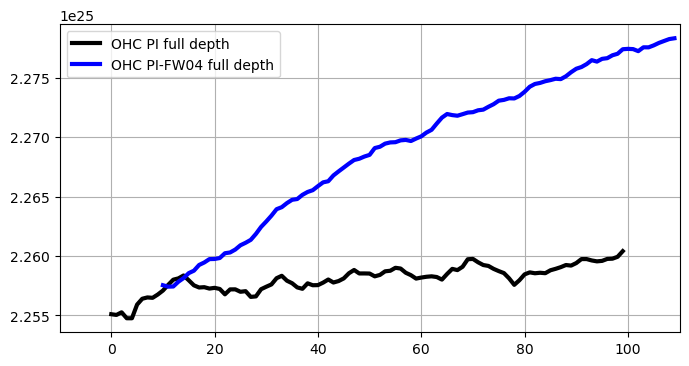

In [11]:
plt.figure(1,figsize=(8,4))
plt.plot(year,varr.sum(['xt_ocean','yt_ocean','st_ocean']),'k',linewidth=3)
plt.plot(year+10,varp04.sum(['xt_ocean','yt_ocean','st_ocean']).mean('ens'),'blue',linewidth=3)
plt.grid()
plt.xlim(-10,110)
plt.legend(['OHC PI full depth','OHC PI-FW04 full depth'])

## Time series --- anomalies

In [12]:
z1=800
OHCanom=varp04.sum(['xt_ocean','yt_ocean','st_ocean'])-varr.mean('year').sum()
OHCanom_upper=varp04.sel(st_ocean=slice(0,z1)).sum(['xt_ocean','yt_ocean','st_ocean'])-varr.mean('year').sel(st_ocean=slice(0,z1)).sum()
OHCanom_upper2=varp04.sel(st_ocean=slice(z1,6000)).sum(['xt_ocean','yt_ocean','st_ocean'])-varr.mean('year').sel(st_ocean=slice(z1,6000)).sum()

(-1e+23, 2.5e+23)

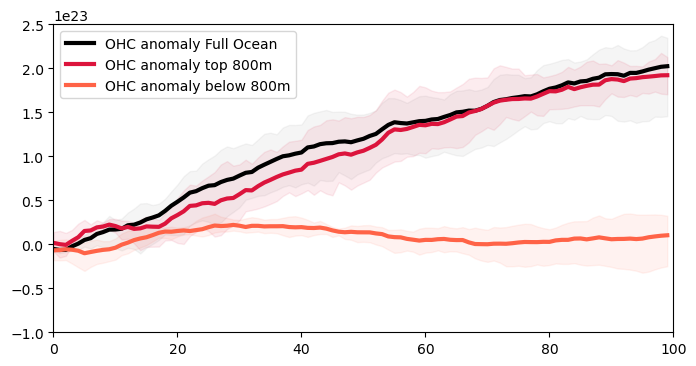

In [17]:
plt.figure(2,figsize=(8,4))
plt.plot(year,OHCanom.mean('ens'),'k',linewidth=3)
plt.plot(year,OHCanom_upper.mean('ens'),'crimson',linewidth=3)
plt.plot(year,OHCanom_upper2.mean('ens'),'tomato',linewidth=3)
plt.fill_between(year,OHCanom.max(dim='ens'),
                OHCanom.min(dim='ens'),color='grey',alpha=0.08)
plt.fill_between(year,OHCanom_upper.max(dim='ens'),
                OHCanom_upper.min(dim='ens'),color='crimson',alpha=0.08)
plt.fill_between(year,OHCanom_upper2.max(dim='ens'),
                OHCanom_upper2.min(dim='ens'),color='tomato',alpha=0.08)
plt.legend(['OHC anomaly Full Ocean','OHC anomaly top '+str(z1)+'m','OHC anomaly below '+str(z1)+'m'])
plt.xlim(0,100)
plt.ylim(-1e23,2.5e23)

### OHC Anomalies

In [11]:
##time interval
t1=0
t2=50
## depth
indz=800

In [20]:
OHCanom_total=varp04[:,t2-10:t2,:,:,:].sel(st_ocean=slice(0,indz)).mean('year').sum('st_ocean')-varr.sel(st_ocean=slice(0,indz)).mean('year').sum('st_ocean')


In [50]:
# fig=plt.figure(2,figsize=(12,7))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-60, globe=None))
# ax.add_feature(cfeature.LAND,color='grey')
# a=ax.contourf(lons,lats,mask*(OHCanom_total/area),
# 	np.arange(-1.5e10,1.51e10,0.1e10),
# 	cmap='RdBu_r',transform=ccrs.PlateCarree(),extend='both')
# plt.colorbar(a)
# plt.title('OHC anomaly PI-FW04 ('+str(t1)+'-'+str(t2)+'yrs)')

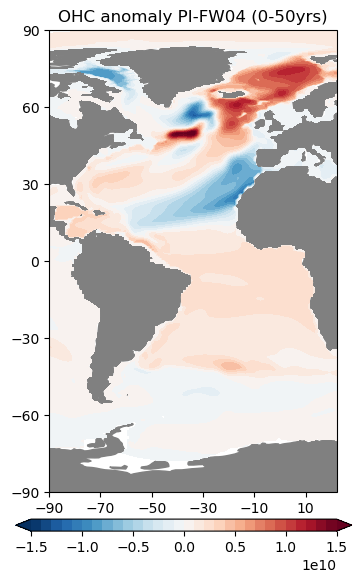

In [22]:
fig=plt.figure(4,figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(-90,41,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,color='grey')
ax.set_extent([-90, 22, -90, 90], crs=ccrs.PlateCarree())
a=ax.contourf(lons,lats,mask*(OHCanom_total.mean('ens')/area),
	np.arange(-1.5e10,1.51e10,0.1e10),
	cmap='RdBu_r',transform=ccrs.PlateCarree(),extend='both')
plt.title('OHC anomaly PI-FW04 ('+str(t1)+'-'+str(t2)+'yrs)')
cax1 = fig.add_axes([ 0.365, 0.045, 0.28, 0.02 ])
cbar1=fig.colorbar(a,cax1,ticks=np.arange(-1.5e10,1.51e10,0.5e10),
	label='',orientation='horizontal',ticklocation='bottom')

## OHC trend (heat storage rate)
### control run OHC trend

In [12]:
OHCr_upper=varr.sel(st_ocean=slice(0,indz)).sum('st_ocean')

In [13]:
timeR=np.arange(0,varr['year'][-1]-varr['year'][0]+1,1)
OHCr_trend=np.zeros((len(varr.yt_ocean),len(varr.xt_ocean)))
for i in range(0,len(varr.xt_ocean)):
	for j in range(0,len(varr.yt_ocean)):
		OHCr_trend[j,i]=np.polyfit(timeR,OHCr_upper[:,j,i],1)[0]

### Perturbation run OHC trend

In [14]:
OHCe_upper=varp04[:,t1:t2,:,:,:].sel(st_ocean=slice(0,indz)).sum('st_ocean')

In [15]:
time=np.arange(0,varp04['year'][-1]-varp04['year'][0]+1,1)

OHCe_trend=np.zeros((len(varp04.ens),len(varp04.yt_ocean),len(varp04.xt_ocean)))
for e in range(0,len(varp04.ens)):
	for i in range(0,len(varp04.xt_ocean)):
		for j in range(0,len(varp04.yt_ocean)):
			OHCe_trend[e,j,i]=np.polyfit(time[t1:t2],OHCe_upper[e,t1:t2,j,i],1)[0]

### OHC change (difference between trends)

In [16]:
OHC_anom=OHCe_trend-OHCr_trend

In [17]:
def interpola(lat,lon,data,lati,loni):
	import scipy.interpolate as inter
	#long,latg=np.meshgrid(lon,lat)
	values=(lon.flatten(),lat.flatten())
	longi,latgi=np.meshgrid(loni,lati)
	xi=(longi.flatten(),latgi.flatten())
	datai = inter.griddata(values,data.flatten(),xi).reshape(latgi.shape)
	return datai

In [18]:
loni=np.arange(varp04.xt_ocean.min(),varp04.xt_ocean.max(),1)
lati=np.arange(-90,91,1)
var_anomi=np.zeros((4,len(lati),len(loni)))
for e in range(0,4):
    var_anomi[e,:,:]=interpola(lats.values,lons.values,OHC_anom[e,:,:],lati,loni)

In [19]:
def same_sign(data,lon,lat,n):
	latsig=np.array([])
	lonsig=np.array([])
	sig=np.zeros((len(lat),len(lon)))
	# indlatsig=np.array([])
	# indlonsig=np.array([])
	for i in range(0,len(lon)):
		for j in range(0,len(lat)):
			a=np.where(data[:,j,i]>0)
			b=np.where(data[:,j,i]<0)
			if len(a[0])>=n or len(b[0])>=n:
				c=np.array([lat[j]]);d=np.array([lon[i]])
				latsig=np.concatenate((latsig,c),axis=0)
				lonsig=np.concatenate((lonsig,d),axis=0)
				sig[j,i]=1
				# indlatsig=np.concatenate((indlatsig,np.array([j])),axis=0)
				# indlonsig=np.concatenate((indlonsig,np.array([i])),axis=0)
	return sig,latsig,lonsig#,np.array(indlatsig,dtype='int'),np.array(indlonsig,dtype='int')

In [20]:
sig,x,x=same_sign(var_anomi[:,::3,::3],loni[::3],lati[::3],4)
sig=np.where(sig==1)

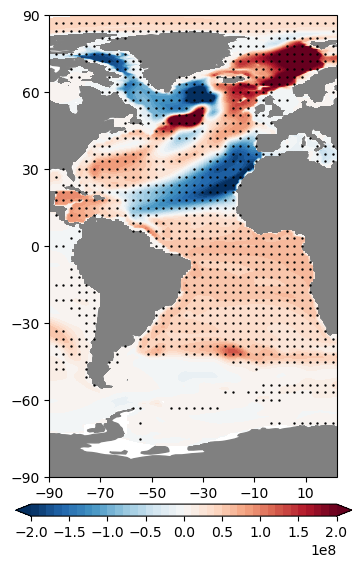

In [21]:
fig=plt.figure(4,figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(-90,41,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,color='grey')
ax.set_extent([-90, 22, -90, 90], crs=ccrs.PlateCarree())
a=ax.contourf(lons,lats,mask*(OHC_anom.mean(axis=0)/area),
	np.arange(-2e8,2.1e8,0.1e8),
	#np.arange(-3e8,3.1e8,0.25e8),
	cmap='RdBu_r',transform=ccrs.PlateCarree(),extend='both')
ax.scatter(loni[::3][sig[1]],lati[::3][sig[0]],marker='o',s=0.5,
		color='black',alpha=1,transform=ccrs.PlateCarree())
# plt.title('OHC tendency PI-FW04 ('+str(t1)+'-'+str(t2)+'yrs)')
cax1 = fig.add_axes([ 0.365, 0.045, 0.28, 0.02 ])
cbar1=fig.colorbar(a,cax1,ticks=np.arange(-2e8,2.1e8,0.5e8),
	label='',orientation='horizontal',ticklocation='bottom')

In [49]:
ens=['PI-FW04NA-01','PI-FW04NA-02','PI-FW04NA-03','PI-FW04NA-04']

(300, 360, 4)

In [62]:
OHC_anom=xr.DataArray((mask*(OHC_anom/area)).values,[('yt_ocean', varp04.yt_ocean.values),('xt_ocean', varp04.xt_ocean.values),('ens', ens)])
OHC_anom.attrs['long_name']='Ocean Heant Content tendency'
OHC_anom.attrs['description']='OHC trend between years 0 and 50, trend of control simulation is removed'
OHC_anom.attrs['units']='J/m**2/year'
OHC_anom.attrs['simulation']='PI-FW04Gr-ic'
OHC_anom.attrs['reference_simulation']='piControl'
OHC_anom.attrs['model']='ACCESS-ESM1-5'
OHC_anom.name='OHC'

### Q net 

In [27]:
sim=['pre-industrial','PI-FW04Gr-ic','PI-FW04Gr-ic-02','PI-FW04Gr-ic-03','PI-FW04Gr-ic-04']
for s in sim:
	z1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/sfc_hflux_coupler_*nc'))
	# z2=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/ocean/sfc_hflux_pme_'+s+'*'))
	z3=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/frazil_2d_*nc'))
	z4=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/sfc_hflux_from_runoff_'+s+'*nc'))
	for f in range(0,len(z1)):
		if f==0:
			coupler=xr.open_dataset(z1[0]).sfc_hflux_coupler
			# pme=xr.open_dataset(z2[0]).sfc_hflux_pme
			frazil=xr.open_dataset(z3[0]).frazil_2d
			# fw=xr.open_dataset(z4[0]).sfc_hflux_from_runoff
		else:
			coupler=xr.concat([coupler,xr.open_dataset(z1[f]).sfc_hflux_coupler],dim='time')
			# pme=xr.concat([pme,xr.open_dataset(z2[f]).sfc_hflux_pme],dim='time')
			frazil=xr.concat([frazil,xr.open_dataset(z3[f]).frazil_2d],dim='time')
			# fw=xr.concat([fw,xr.open_dataset(z4[f]).sfc_hflux_from_runoff],dim='time')

	Qnet = (coupler+frazil)*60*60*24*30*area #(coupler+frazil+pme+fw)

	if s=='lig127k' or s=='pre-industrial':
		Qnetr=Qnet
	elif s=='PI-FW04Gr-ic':
		Qnet04_1=Qnet
	elif s=='PI-FW04Gr-ic-02':
		Qnet04_2=Qnet
	elif s=='PI-FW04Gr-ic-03':
		Qnet04_3=Qnet
	elif s=='PI-FW04Gr-ic-04':
		Qnet04_4=Qnet

In [28]:
time=pd.date_range('1900-01-01','2000-01-01',freq='M') 

x1=xr.DataArray(Qnet04_1[:1200,:,:],coords={'time':time,'yt_ocean':Qnet04_1.yt_ocean,'xt_ocean':Qnet04_1.xt_ocean},
    dims=['time','yt_ocean','xt_ocean'])
x2=xr.DataArray(Qnet04_2,coords={'time':time,'yt_ocean':Qnet04_1.yt_ocean,'xt_ocean':Qnet04_1.xt_ocean},
    dims=['time','yt_ocean','xt_ocean'])
x3=xr.DataArray(Qnet04_3,coords={'time':time,'yt_ocean':Qnet04_1.yt_ocean,'xt_ocean':Qnet04_1.xt_ocean},
    dims=['time','yt_ocean','xt_ocean'])
x4=xr.DataArray(Qnet04_4,coords={'time':time,'yt_ocean':Qnet04_1.yt_ocean,'xt_ocean':Qnet04_1.xt_ocean},
    dims=['time','yt_ocean','xt_ocean'])

Qnet04=xr.concat([x1,x2,x3,x4],dim='ens')

del Qnet04_1; del Qnet04_2; del Qnet04_3; del Qnet04_4

### Taking the trend of the control run

In [29]:
Qnetr = Qnetr.cumsum(dim='time')
Qnetr=Qnetr.groupby('time.year').mean(dim='time')

Qnetr_trend=np.zeros((len(Qnetr.yt_ocean),len(Qnetr.xt_ocean)))
for i in range(0,len(Qnetr.xt_ocean)):
	for j in range(0,len(Qnetr.yt_ocean)):
		Qnetr_trend[j,i]=np.polyfit(timeR,Qnetr[:,j,i],1)[0]

### Taking the trend of the Pertubation run

In [30]:
print(t1)
print(t2)

0
50


In [31]:
Qnete2 = Qnet04[:,t1*12:t2*12,:,:].cumsum(dim='time')
Qnete2=Qnete2.groupby('time.year').mean(dim='time')

Qnete2_trend=np.zeros((len(Qnete2.ens),len(Qnete2.yt_ocean),len(Qnete2.xt_ocean)))
for e in range(0,len(Qnete2.ens)):
	for i in range(0,len(Qnete2.xt_ocean)):
		for j in range(0,len(Qnete2.yt_ocean)):
			Qnete2_trend[e,j,i]=np.polyfit(year[t1:t2],Qnete2[e,:,j,i],1)[0]        

In [32]:
Qnet_anom=Qnete2_trend-Qnetr_trend

In [33]:
loni=np.arange(varp04.xt_ocean.min(),varp04.xt_ocean.max(),1)
lati=np.arange(-90,91,1)
Qnet_anomi=np.zeros((4,len(lati),len(loni)))
for e in range(0,4):
    Qnet_anomi[e,:,:]=interpola(lats.values,lons.values,Qnet_anom[e,:,:],lati,loni)

sig,x,x=same_sign(Qnet_anomi[:,::3,::3],loni[::3],lati[::3],4)
sig=np.where(sig==1)

In [34]:
# fig=plt.figure(2,figsize=(12,7))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-60, globe=None))
# ax.add_feature(cfeature.LAND,color='grey')
# a=ax.contourf(lons,lats,mask*(Qnet_anom/area),
# 	np.arange(-8e8,8.1e8,0.5e8),
# 	cmap='RdBu_r',transform=ccrs.PlateCarree(),extend='both')
# plt.colorbar(a)
# plt.title('Heat uptake rate PI-FW04 ('+str(t1)+'-'+str(t2)+'yrs)')

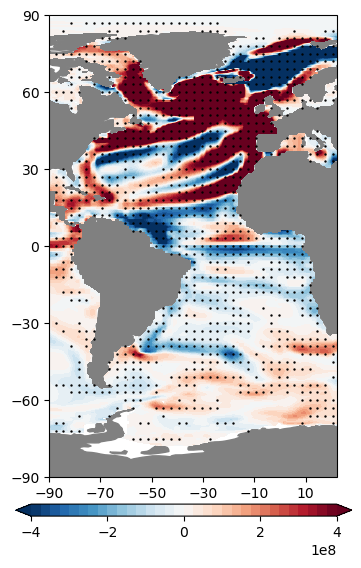

In [35]:
fig=plt.figure(4,figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(-90,41,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,color='grey')
ax.set_extent([-90, 22, -90, 90], crs=ccrs.PlateCarree())
a=ax.contourf(lons,lats,mask*(Qnet_anom.mean(axis=0)/area),
	np.arange(-4e8,4.01e8,0.25e8),
	cmap='RdBu_r',transform=ccrs.PlateCarree(),extend='both')
ax.scatter(loni[::3][sig[1]],lati[::3][sig[0]],marker='o',s=0.5,
		color='black',alpha=1,transform=ccrs.PlateCarree())
# plt.title('Heat uptake rate PI-FW04 ('+str(t1)+'-'+str(t2)+'yrs)')
cax1 = fig.add_axes([ 0.365, 0.045, 0.28, 0.02 ])
cbar1=fig.colorbar(a,cax1,ticks=np.arange(-4e8,4.1e8,2e8),
	label='',orientation='horizontal',ticklocation='bottom')

In [55]:
a.shape

(4, 300, 360)

In [61]:
a = mask.values*(Qnet_anom/area.values)
a=xr.DataArray(a,[('ens', ens),('yt_ocean', varp04.yt_ocean.values),('xt_ocean', varp04.xt_ocean.values)])
a.attrs['long_name']='Surface heat flux tendency'
a.attrs['description']='linear trend between years 0 and 50, trend of control simulation is removed'
a.attrs['units']='J/m**2/year'
a.attrs['simulation']='PI-FW04Gr-ic'
a.attrs['reference_simulation']='piControl'
a.attrs['model']='ACCESS-ESM1-5'
a.name='Qnet'

# Heat transport rate

In [39]:
Qtransp_trend=OHC_anom-Qnet_anom

In [41]:
loni=np.arange(varp04.xt_ocean.min(),varp04.xt_ocean.max(),1)
lati=np.arange(-90,91,1)
Qtransp_anomi=np.zeros((4,len(lati),len(loni)))
for e in range(0,4):
    Qtransp_anomi[e,:,:]=interpola(lats.values,lons.values,Qtransp_trend[e,:,:].values,lati,loni)

sig,x,x=same_sign(Qtransp_anomi[:,::3,::3],loni[::3],lati[::3],4)
sig=np.where(sig==1)

In [42]:
# fig=plt.figure(2,figsize=(12,7))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-60, globe=None))
# ax.add_feature(cfeature.LAND,color='grey')
# a=ax.contourf(lons,lats,mask*(Qtransp_trend/area),
# 	np.arange(-8e8,8.1e8,0.5e8),	
# 	cmap='RdBu_r',transform=ccrs.PlateCarree(),extend='both')
# plt.colorbar(a)
# plt.title('Heat transport rate PI-FW04 ('+str(t1)+'-'+str(t2)+'yrs)')


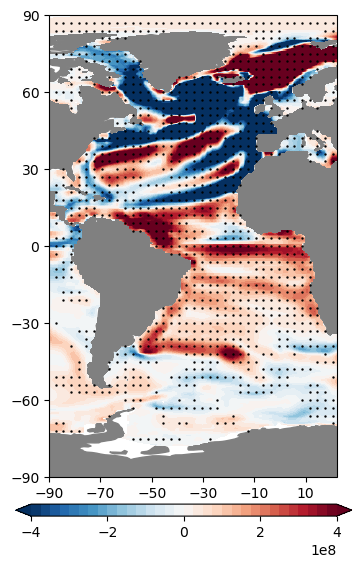

In [43]:
fig=plt.figure(4,figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(-90,41,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,color='grey')
ax.set_extent([-90, 22, -90, 90], crs=ccrs.PlateCarree())
a=ax.contourf(lons,lats,mask*(Qtransp_trend.mean(axis=0)/area),
	np.arange(-4e8,4.01e8,0.25e8),	
	cmap='RdBu_r',transform=ccrs.PlateCarree(),extend='both')
ax.scatter(loni[::3][sig[1]],lati[::3][sig[0]],marker='o',s=0.5,
		color='black',alpha=1,transform=ccrs.PlateCarree())
#plt.title('Heat transport rate PI-FW04 ('+str(t1)+'-'+str(t2)+'yrs)')
cax1 = fig.add_axes([ 0.365, 0.045, 0.28, 0.02 ])
cbar1=fig.colorbar(a,cax1,ticks=np.arange(-4e8,4.1e8,2e8),
	label='',orientation='horizontal',ticklocation='bottom')

In [60]:
b = mask.values*(Qtransp_trend/area.values)
b=xr.DataArray(b,[('ens', ens),('yt_ocean', varp04.yt_ocean.values),('xt_ocean', varp04.xt_ocean.values)])
b.attrs['long_name']='tendency ocean heat transport divergence'
b.attrs['description']='linear trend between years 0 and 50, trend of control simulation is removed'
b.attrs['units']='J/m**2/year'
b.attrs['simulation']='PI-FW04Gr-ic'
b.attrs['reference_simulation']='piControl'
b.attrs['model']='ACCESS-ESM1-5'
b.name='div_OHT'

In [1]:
data = xr.merge([OHC_anom,a,b])
del data.attrs['long_name']
del data.attrs['description']
del data.attrs['units']
del data.attrs['simulation']
del data.attrs['reference_simulation']
del data.attrs['model']
data

NameError: name 'xr' is not defined

In [ ]:
dir_out='/g/data/y99/gp9664/data_AMOC_NGEO/'
myvar.to_netcdf(dir_out+'Fig4c_Sswsa_ACCESS-ESM1-5_CMIP6_hist_ssp585.nc','w’)
